In [1]:
from cmb.configs.utils import Configs
from cmb.datasets.jetclass import JetDataclass, ParticleClouds

config = Configs('aoj_epic_cmb.yaml') 
jets = JetDataclass(config.data, task='train')

INFO: created experiment instance GaussNoise_to_AspenOpenJets_FlowMatching_TelegraphProcess_HybridEPiC_2024.11.09_10h19_9977


/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/df630/CMB/src/cmb/datasets/utils.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


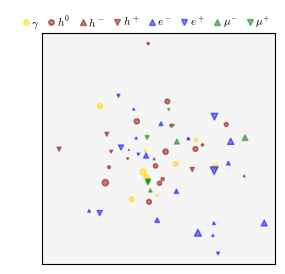

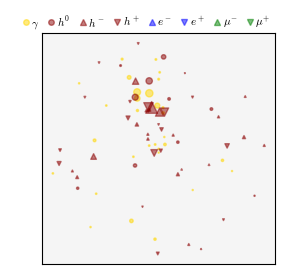

In [14]:
jets.source.display_cloud(10, scale_marker=10)
jets.target.display_cloud(10, scale_marker=2)

2024-11-09 10:20:54.781492: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 10:20:54.821893: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 10:20:54.822697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 10:20:55.484057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  TelegraphProcess
      - solver method:  EulerLeapingSolver
INFO: Preprocessing data...
    - continuous data: standardize
    - discrete data: states


INFO: number of training parameters: 827718
INFO: start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.9/0.1/0.0
INFO: train size: 64443, validation size: 7160, testing sizes: 0


epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
	Epoch: 1, train loss: 4.0808624653589165, valid loss: 3.827357292175293  (min valid loss: 3.827357292175293)
	Epoch: 11, train loss: 3.421656154450916, valid loss: 3.42655576978411  (min valid loss: 3.42655576978411)
	Epoch: 21, train loss: 3.2726307293725387, valid loss: 3.274490935461862  (min valid loss: 3.274490935461862)
	Epoch: 31, train loss: 3.2184229881044413, valid loss: 3.204830953053066  (min valid loss: 3.2

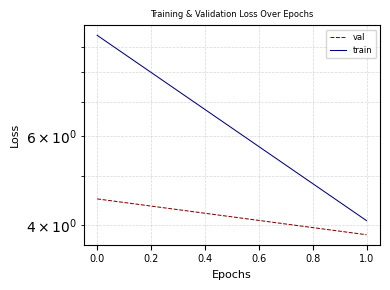

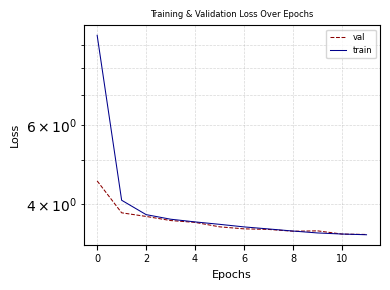

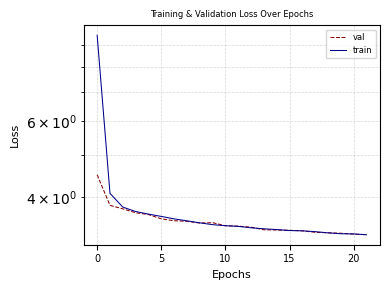

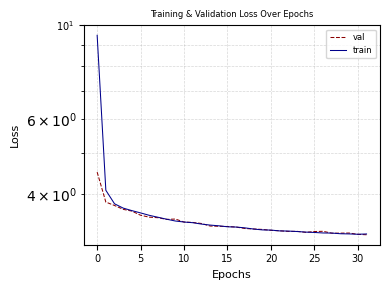

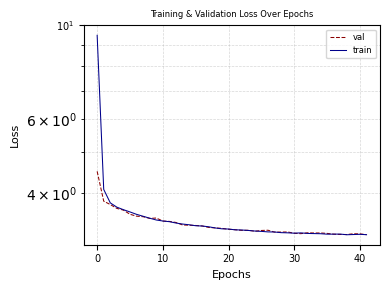

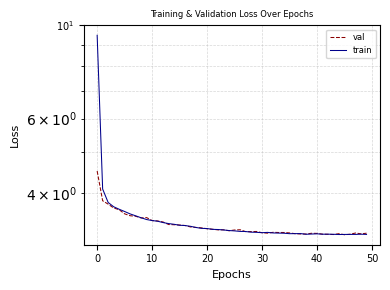

In [2]:
from cmb.models.trainers import GenerativeDynamicsModule
cmb = GenerativeDynamicsModule(config, jets)
cmb.train()

In [35]:

import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from cmb.datasets.jetclass import JetDataclass, ParticleClouds

num_jets = 10000
cmb.config.pipeline.num_timesteps = 200
cmb.config.pipeline.time_eps = 0.001

test = JetDataclass(cmb.config.data, task='test', num_jets=num_jets)
test.source.preprocess(output_continuous=cmb.config.data.preprocess.continuous,
                       output_discrete=cmb.config.data.preprocess.discrete)

cmb.generate(source_continuous=test.source.continuous, 
             source_discrete=test.source.discrete,
             mask=test.source.mask,
             dataclass = ParticleClouds,
             output_history=False
             ) 

INFO: generating samples...


batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
import torch
import numpy as np
import awkward as ak
import fastjet
import vector
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from dataclasses import dataclass
plt.rcParams['mathtext.fontset']= 'cm'
plt.rcParams['figure.autolayout'] = False

vector.register_awkward()

from cmb.datasets.utils import (extract_jetclass_features, 
                                extract_aoj_features, 
                                sample_noise, 
                                sample_masks, 
                                flavor_to_onehot, 
                                states_to_flavor)

class JetDataclass:
    ''' class that prepares the source-target coupling
    '''
    def __init__(self, config, task, num_jets=None):
        assert task=='train' or task=='test', 'Please specify downstream task: `train`, `test`'
        kwargs_target = config.target.params.to_dict()
        kwargs_source = config.source.params.to_dict()
        
        #...target:

        self.target = ParticleClouds(dataset=config.target.name,
                                     data_paths=getattr(config.target.train, 'path', None) if task == 'train' else getattr(config.target.test, 'path', None),
                                     **kwargs_target)

        #... noise source:
        
        kwargs_source['set_masks_like'] = self.target.multiplicity 
        kwargs_source['num_jets'] = len(self.target) if num_jets is None else num_jets

        self.source = ParticleClouds(dataset=config.source.name,
                                     data_paths=getattr(config.source.train, 'path', None) if task == 'train' else getattr(config.source.test, 'path', None),
                                     **kwargs_source)        

class ParticleClouds:
    def __init__(self, 
                 dataset='JetClass',
                 data_paths=None,
                 **data_params
                 ):
    
        if isinstance(dataset, torch.Tensor):
            self.continuous, self.discrete, self.mask  = dataset[..., :3], dataset[..., 3:-1].long(), dataset[..., -1].unsqueeze(-1).long()
            if not self.discrete.nelement():
                del self.discrete

        elif 'JetClass' in dataset:
            assert data_paths is not None, 'Specify the path to the JetClass dataset'
            self.continuous, self.discrete, self.mask = extract_jetclass_features(data_paths,  **data_params)
       
        elif 'AspenOpenJets' in dataset:
            assert data_paths is not None, 'Specify the path to the AspenOpenJet dataset'
            self.continuous, self.discrete, self.mask = extract_aoj_features(data_paths, **data_params)

        elif 'Noise' in dataset:
            self.continuous, self.discrete = sample_noise(dataset, **data_params) 
            self.mask = sample_masks(**data_params)
            self.continuous *= self.mask
            self.discrete *= self.mask

        #...attributes:

        self.pt = self.continuous[...,0] 
        self.eta_rel = self.continuous[...,1]
        self.phi_rel = self.continuous[...,2]
        self.multiplicity = torch.sum(self.mask, dim=1)

        if hasattr(self,'discrete'):
            self.flavor = self.discrete[..., :-1]
            self.charge = self.discrete[..., -1]


    def __len__(self):
        return self.continuous.shape[0]

    def compute_4mom(self):
        self.px = self.pt * torch.cos(self.phi_rel)
        self.py = self.pt * torch.sin(self.phi_rel)
        self.pz = self.pt * torch.sinh(self.eta_rel)
        self.e = self.pt * torch.cosh(self.eta_rel)
        
    #...data processing methods

    def summary_stats(self):
        mask = self.mask.squeeze(-1) > 0
        data = self.continuous[mask]
        return {'mean': data.mean(0).tolist(),
                'std': data.std(0).tolist(),
                'min': data.min(0).values.tolist(),
                'max': data.max(0).values.tolist()}

    def preprocess(self, 
                   output_continuous='standardize', 
                   output_discrete='states',
                   stats=None):
        
        if output_discrete == 'onehot_dequantize':
            one_hot = flavor_to_onehot(self.discrete[..., :-1],  self.discrete[..., -1])
            self.continuous = torch.cat([self.continuous, one_hot], dim=-1)
            del self.discrete
        elif output_discrete == 'states':
            one_hot = flavor_to_onehot(self.discrete[..., :-1],  self.discrete[..., -1])
            self.discrete = torch.argmax(one_hot, dim=-1).unsqueeze(-1).long()

        if output_continuous == 'standardize':
            self.stats = self.summary_stats() if stats is None else stats
            self.continuous = (self.continuous - torch.tensor(self.stats['mean'])) / (torch.tensor(self.stats['std'])) 
            self.continuous *= self.mask
            self.pt = self.continuous[...,0] 
            self.eta_rel = self.continuous[...,1]
            self.phi_rel = self.continuous[...,2]

    def postprocess(self, 
                    input_continuous='standardize', 
                    input_discrete='states',
                    stats=None):
        
        if input_continuous == 'standardize':                 
            if input_discrete == 'onehot_dequantize':
                self.continuous = torch.cat([self.continuous, self.discrete], dim=-1)
                
            stats = getattr(self, 'stats', stats)
            self.continuous = (self.continuous * torch.tensor(stats['std'])) + torch.tensor(stats['mean'])
            self.continuous *= self.mask
            self.pt = self.continuous[...,0] 
            self.eta_rel = self.continuous[...,1]
            self.phi_rel = self.continuous[...,2]

        if input_discrete == 'onehot_dequantize':
            discrete = torch.argmax(self.continuous[...,3:], dim=-1).unsqueeze(-1).long()
            self.flavor, self.charge = states_to_flavor(discrete)
            self.discrete = torch.cat([self.flavor, self.charge], dim=-1)
            self.flavor *= self.mask
            self.charge *= self.mask
            self.discrete *= self.mask
            self.continuous = self.continuous[...,:3]

        if input_discrete == 'states':
            self.flavor, self.charge = states_to_flavor(self.discrete)
            self.discrete = torch.cat([self.flavor, self.charge], dim=-1)
            self.flavor *= self.mask
            self.charge *= self.mask
            self.discrete *= self.mask            

    #...data visualization methods

    def histplot(self, feature='pt',  idx=None, xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), fontsize=12, ax=None, **kwargs):
        mask = self.mask.squeeze(-1) > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        x = getattr(self, feature)[mask] if idx is None else getattr(self, feature)[:,idx]
        sns.histplot(x=x, element="step", ax=ax, **kwargs) 
        ax.set_xlabel(feature if xlabel is None else xlabel, fontsize=fontsize)
        ax.set_ylabel(ylabel, fontsize=fontsize)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def display_cloud(self, idx, scale_marker=1.0, ax=None, figsize=(3,3), facecolor='whitesmoke', color='darkblue', title_box_anchor=(1.025,1.125), savefig=None):
        eta = self.eta_rel[idx]
        phi = self.phi_rel[idx]
        pt = self.pt[idx] * scale_marker 
        flavor = torch.argmax(self.flavor[idx], dim=-1)
        q = self.charge[idx]
        mask = self.mask[idx]
        pt = pt[mask.squeeze(-1) > 0]
        eta = eta[mask.squeeze(-1) > 0]
        phi = phi[mask.squeeze(-1) > 0]
        flavor = flavor[mask.squeeze(-1) > 0]
        charge = q[mask.squeeze(-1) > 0]

        if ax is None: _, ax = plt.subplots(figsize=figsize)            

        ax.scatter(eta[flavor==0], phi[flavor==0], marker='o', s=pt[flavor==0], color='gold', alpha=0.5,  label=r'$\gamma$')
        ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=pt[flavor==1], color='darkred', alpha=0.5, label=r'$h^{0}$')
        ax.scatter(eta[(flavor==2) & (charge<0)], phi[(flavor==2) & (charge<0)], marker='^', s=pt[(flavor==2) & (charge<0)], color='darkred', alpha=0.5,  label=r'$h^{-}$')
        ax.scatter(eta[(flavor==2) & (charge>0)], phi[(flavor==2) & (charge>0)], marker='v', s=pt[(flavor==2) & (charge>0)], color='darkred', alpha=0.5,  label=r'$h^{+}$')
        ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=pt[(flavor==3) & (charge<0)], color='blue', alpha=0.5,  label=r'$e^{-}$')
        ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=pt[(flavor==3) & (charge>0)], color='blue', alpha=0.5,  label=r'$e^{+}$')
        ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=pt[(flavor==4) & (charge<0)], color='green', alpha=0.5,  label=r'$\mu^{-}$')
        ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=pt[(flavor==4) & (charge>0)], color='green', alpha=0.5,  label=r'$\mu^{+}$')

        # Define custom legend markers
        h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
        h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
        h3 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='darkred', linestyle='None')
        h4 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='darkred', linestyle='None')
        h5 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='blue', linestyle='None')
        h6 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='blue', linestyle='None')
        h7 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='green', linestyle='None')
        h8 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='green', linestyle='None')

        plt.legend([h1, h2, h3, h4, h5, h6, h7, h8], 
                [r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^{-}$', r'$\mu^{+}$'], 
                loc="upper right", 
                markerscale=2, 
                scatterpoints=1, 
                fontsize=8,  
                frameon=False,
                ncol=8,
                bbox_to_anchor=title_box_anchor,
                handletextpad=-0.5,  
                columnspacing=.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_facecolor(facecolor)  # Set the same color for the axis background
        if savefig is not None:
            plt.savefig(savefig)

class JetClassHighLevelFeatures:
    def __init__(self, constituents: ParticleClouds):

        self.constituents = constituents

        #...compute jet kinematics:
        self.constituents.compute_4mom()
        self.px = self.constituents.px.sum(axis=-1)
        self.py = self.constituents.py.sum(axis=-1)
        self.pz = self.constituents.pz.sum(axis=-1)
        self.e = self.constituents.e.sum(axis=-1)
        self.pt = torch.clamp_min(self.px**2 + self.py**2, 0).sqrt()
        self.m = torch.clamp_min(self.e**2 - self.px**2 - self.py**2 - self.pz**2, 0).sqrt()
        self.eta = 0.5 * torch.log((self.pt + self.pz) / (self.pt - self.pz))
        self.phi = torch.atan2(self.py, self.px)

        # discrete jet features
        self.multiplicity = torch.sum(self.constituents.mask, dim=1)
        if hasattr(self.constituents, 'discrete'):
            self.Q_total = self.jet_charge(kappa=0.0)
            self.Q_jet = self.jet_charge(kappa=1.0)

        #...subsstructure
        self.R = 0.8
        self.beta = 1.0
        self.use_wta_scheme = True
        # self.constituents = self.constituents[ak.num(self.constituents) >= 3]
        self.substructure()

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), fontsize=12, ax=None, **kwargs):
        x = getattr(self, features)
        if isinstance(x, torch.Tensor): x.cpu().numpy()
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=x, element="step", ax=ax, **kwargs) 
        ax.set_xlabel(features if xlabel is None else xlabel, fontsize=fontsize)
        ax.set_ylabel(ylabel, fontsize=fontsize)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def jet_charge(self, kappa):
        ''' jet charge defined as Q_j^kappa = Sum_i Q_i * (pT_i / pT_jet)^kappa
        '''
        Qjet = self.constituents.charge.squeeze(-1) * (self.constituents.pt)**kappa
        return Qjet.sum(axis=1) / (self.pt**kappa) 
    
    def histplot_multiplicities(self, state=None, xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), fontsize=12, ax=None, **kwargs):
        if state is not None:
            if isinstance(state, int):
                state = [state]
            multiplicity = torch.zeros(self.constituents.discrete.shape[0], 1)
            for s in state:
                x = (torch.argmax(self.constituents.discrete, dim=-1).unsqueeze(-1) == s) * self.constituents.mask
                multiplicity += x.sum(dim=1)
        else:
            multiplicity = self.multiplicity

        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=multiplicity.squeeze(-1), element="step", ax=ax, discrete=True, **kwargs) 
        ax.set_xlabel(xlabel, fontsize=fontsize)
        ax.set_ylabel(ylabel, fontsize=fontsize)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def flavor_fractions(self, figsize=(3,3), fontsize=12, ax=None, **kwargs):
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)                                          
        sns.histplot(self.constituents.discrete[self.constituents.mask].squeeze(), binrange=(-0.1, 7.1), element="step", ax=ax, discrete=True, **kwargs)
        ax.legend(loc='upper right', fontsize=8)
        ax.set_xlabel('Particle flavor', fontsize=fontsize)
        ax.set_xticks(np.arange(8))
        ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'])

    def substructure(self):
        constituents_ak = ak.zip({ "pt": np.array(self.constituents.pt),
                                   "eta": np.array(self.constituents.eta_rel),
                                   "phi": np.array(self.constituents.phi_rel),
                                   "mass": np.zeros_like(np.array(self.constituents.pt))
                                   },
                                  with_name="Momentum4D")

        constituents_ak = ak.mask(constituents_ak, constituents_ak.pt > 0)
        constituents_ak = ak.drop_none(constituents_ak)
        self.constituents_ak = constituents_ak[ak.num(constituents_ak) >= 3]
        if self.use_wta_scheme:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R, fastjet.WTA_pt_scheme)
        else:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R)
        print("Clustering jets with fastjet")
        print("Jet definition:", jetdef)
        self.cluster = fastjet.ClusterSequence(self.constituents_ak, jetdef)
        self.inclusive_jets = self.cluster.inclusive_jets()
        self.exclusive_jets_1 = self.cluster.exclusive_jets(n_jets=1)
        self.exclusive_jets_2 = self.cluster.exclusive_jets(n_jets=2)
        self.exclusive_jets_3 = self.cluster.exclusive_jets(n_jets=3)
        print("Calculating N-subjettiness")
        self._calc_d0()
        self._calc_tau1()
        self._calc_tau2()
        self._calc_tau3()
        self.tau21 = np.ma.divide(self.tau2, self.tau1)
        self.tau32 = np.ma.divide(self.tau3, self.tau2)
        print("Calculating D2")
        # D2 as defined in https://arxiv.org/pdf/1409.6298.pdf
        self.d2 = self.cluster.exclusive_jets_energy_correlator(njets=1, func="d2")

    def _calc_deltaR(self, particles, jet):
        jet = ak.unflatten(ak.flatten(jet), counts=1)
        return particles.deltaR(jet)

    def _calc_d0(self):
        """Calculate the d0 values."""
        self.d0 = ak.sum(self.constituents_ak.pt * self.R**self.beta, axis=1)

    def _calc_tau1(self):
        """Calculate the tau1 values."""
        self.delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_1[:, :1])
        self.pt_i = self.constituents_ak.pt
        self.tau1 = ak.sum(self.pt_i * self.delta_r_1i**self.beta, axis=1) / self.d0

    def _calc_tau2(self):
        """Calculate the tau2 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, 1:2])
        self.pt_i = self.constituents_ak.pt
        # add new axis to make it broadcastable
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau2 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def _calc_tau3(self):
        """Calculate the tau3 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 1:2])
        delta_r_3i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 2:3])
        self.pt_i = self.constituents_ak.pt
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                    delta_r_3i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau3 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def histogram(self, features='pt', density=True, num_bins=100, use_quantiles=False):
        x = getattr(self, features)
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wassertein1D(self, feature, reference):
        x = getattr(self, feature)
        y = getattr(reference, feature)
        return scipy.stats.wasserstein_distance(x, y)
            



In [37]:
# from cmb.datasets.jetclass import JetClassHighLevelFeatures

data = JetClassHighLevelFeatures(cmb.sample)
test = JetClassHighLevelFeatures(test.target)  

from cmb.datasets.utils import flavor_to_onehot, states_to_flavor

def flavor_fracs(data: JetClassHighLevelFeatures):
    states = torch.argmax(flavor_to_onehot(data.constituents.flavor, data.constituents.charge.squeeze(-1)), dim=-1)
    mask = data.constituents.mask.squeeze(-1) > 0
    return states[mask]

gen_fracs = flavor_fracs(data)
test_fracs = flavor_fracs(test)

Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination


Calculating N-subjettiness
Calculating D2
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
Calculating D2


In [38]:
arg_test = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, False), color='silver', lw=0.25, label='AspenOpenJets')
arg_gen = dict(stat='density', fill=False,log_scale=(False, False), color='crimson', lw=1.25,  label='Hybrid model')
arg_test_log = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, True), color='silver', lw=0.25, label='AspenOpenJets')
arg_gen_log = dict(stat='density', fill=False,log_scale=(False, True), color='crimson', lw=1.25,  label='Hybrid model')


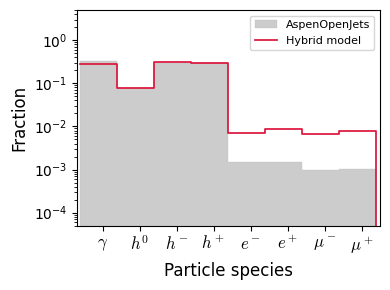

In [39]:
_, ax = plt.subplots(figsize=(4,3))                                          
sns.histplot(test_fracs, binrange=(-0.1, 7), ax=ax, element='step', discrete=True, **arg_test_log)
sns.histplot(gen_fracs, binrange=(-0.1, 7), ax=ax, element='step', discrete=True, **arg_gen_log)
ax.legend(loc='upper right', fontsize=8)
ax.set_xlabel('Particle species', fontsize=12)
ax.set_ylabel('Fraction', fontsize=12)
ax.set_xticks(np.arange(8))
ax.set_xlim(-0.7, 7.5)
ax.set_ylim(5e-5, 5)
ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'], fontsize=12)
plt.savefig(cmb.workdir / f'flavor_fracs_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.tight_layout()
plt.show()

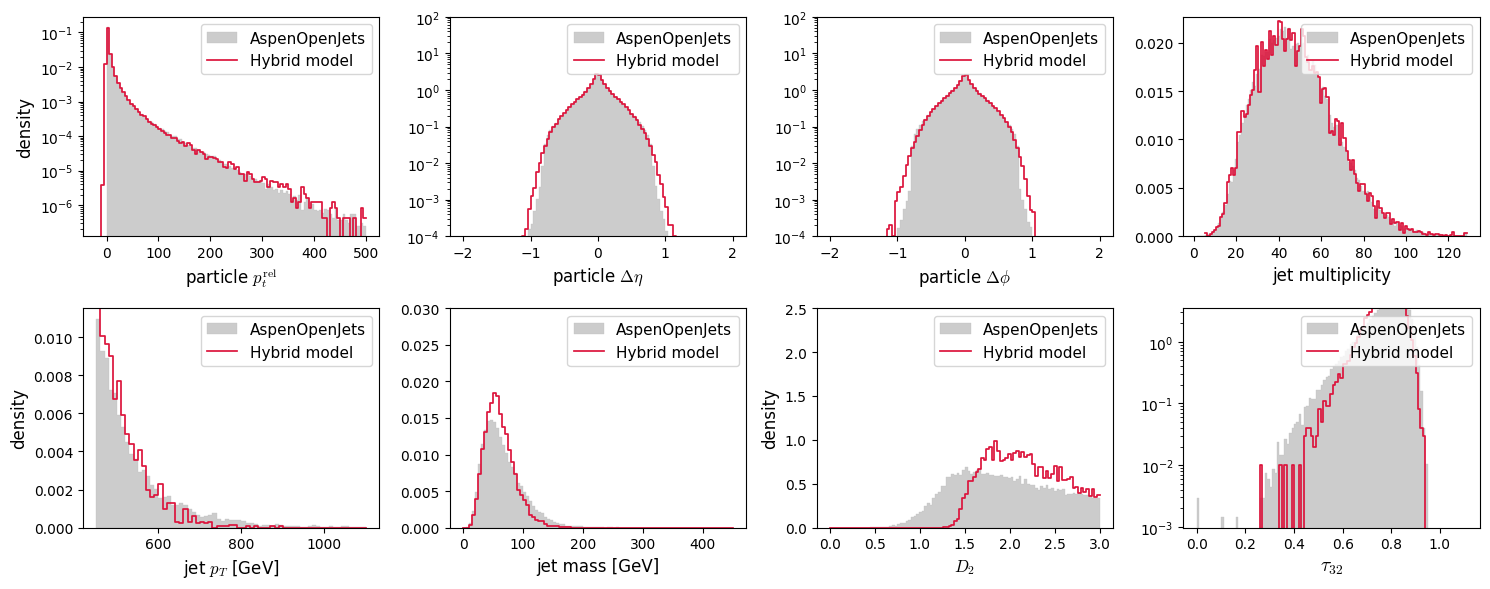

In [40]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(2,4,figsize=(15,6))

binrange, binwidth = (-20, 500), 5
test.constituents.histplot('pt', binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_test_log)
data.constituents.histplot('pt', binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ylabel='density' , ax=ax[0,0], **arg_gen_log)
ax[0,0].legend(loc='upper right', fontsize=11)

binrange, binwidth, ylim = (-2, 2), 0.04, (1e-4, 100)
test.constituents.histplot('eta_rel',  ylim=ylim, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_test_log)
data.constituents.histplot('eta_rel',  ylim=ylim, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_gen_log)
ax[0,1].legend(loc='upper right', fontsize=11)

binrange, binwidth, ylim = (-2, 2), 0.04, (1e-4, 100)
test.constituents.histplot('phi_rel', ylim=ylim, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_test_log)
data.constituents.histplot('phi_rel', ylim=ylim, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_gen_log)
ax[0,2].legend(loc='upper right', fontsize=11)

test.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_test)
data.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_gen)
ax[0,3].legend(loc='upper right', fontsize=11)

# ------------------------------

binrange, binwidth = (450, 1100), 10
test.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_test)
data.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_gen)
ax[1,0].legend(loc='upper right', fontsize=11)

binrange, binwidth,  ylim = (0, 450), 5, (0, 0.03)
test.histplot('m',  xlabel=r'jet mass [GeV]',  ylim=ylim, ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_test)
data.histplot('m',  xlabel=r'jet mass [GeV]',  ylim=ylim, ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_gen)
ax[1,1].legend(loc='upper right', fontsize=11)

binrange, binwidth, ylim = (0, 3.0), 0.03, (0, 2.5)
test.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ylim=ylim, ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_test)
data.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ylim=ylim, ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_gen)
ax[1,2].legend(loc='upper right', fontsize=11)

binrange, binwidth, ylim = (0, 1.1), 0.01, (0, 3.5)
test.histplot('tau32',  xlabel=r'$\tau_{32}$',  ylim=ylim, ax=ax[1,3], binrange=binrange, binwidth=binwidth, fontsize=14, **arg_test_log)
data.histplot('tau32',  xlabel=r'$\tau_{32}$',  ylim=ylim, ax=ax[1,3], binrange=binrange, binwidth=binwidth, fontsize=14, **arg_gen_log)
ax[1,3].legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(cmb.workdir / f'features_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.show()




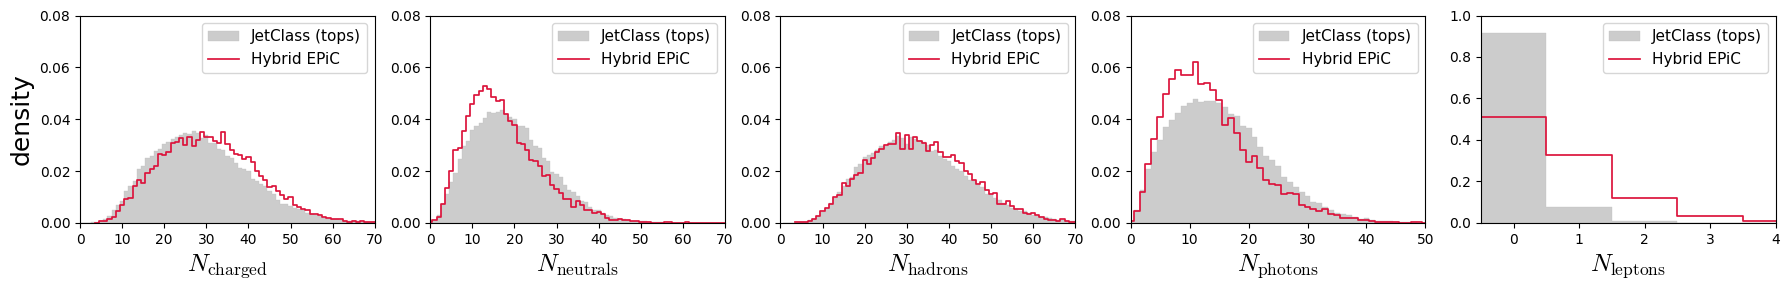

In [41]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,5,figsize=(18,3))

arg_test = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, False), color='silver', lw=0.25, label='JetClass (tops)')
arg_gen = dict(stat='density', fill=False,log_scale=(False, False), color='crimson', lw=1.25,  label='Hybrid EPiC')
arg_test_log = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, True), color='silver', lw=0.25, label='JetClass (tops)')
arg_gen_log = dict(stat='density', fill=False,log_scale=(False, True), color='crimson', lw=1.25,  label='Hybrid EPiC')

xlim, ylim = (0, 70), (0, 0.08)
test.histplot_multiplicities(state=[2,3,4], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm charged}$', ylabel='density', fontsize=18, ax=ax[0], **arg_test)
data.histplot_multiplicities(state=[2,3,4], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm charged}$', ylabel='density', fontsize=18, ax=ax[0], **arg_gen)
ax[0].legend(loc='upper right', fontsize=11)

xlim, ylim = (0, 70), (0, 0.08)
test.histplot_multiplicities(state=[0,1], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm neutrals}$', fontsize=18, ax=ax[1], **arg_test)
data.histplot_multiplicities(state=[0,1], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm neutrals}$', fontsize=18, ax=ax[1], **arg_gen)
ax[1].legend(loc='upper right', fontsize=11)

xlim, ylim = (0, 70), (0, 0.08)
test.histplot_multiplicities(state=[1,2], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm hadrons}$', fontsize=18, ax=ax[2], **arg_test)
data.histplot_multiplicities(state=[1,2], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm hadrons}$', fontsize=18, ax=ax[2], **arg_gen)
ax[2].legend(loc='upper right', fontsize=11)

xlim, ylim = (0, 50), (0, 0.08)
test.histplot_multiplicities(state=0, xlabel=r'$N_{\rm photons}$', xlim=xlim, ylim=ylim, fontsize=18, ax=ax[3], **arg_test)
data.histplot_multiplicities(state=0, xlabel=r'$N_{\rm photons}$', xlim=xlim, ylim=ylim, fontsize=18, ax=ax[3], **arg_gen)
ax[3].legend(loc='upper right', fontsize=11)

xlim, ylim = (-0.5,4), (0, 1.0)
test.histplot_multiplicities(state=[4,5], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm leptons}$', fontsize=18, ax=ax[4], **arg_test)
data.histplot_multiplicities(state=[4,5], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm leptons}$', fontsize=18, ax=ax[4], **arg_gen)
ax[4].legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(cmb.workdir / f'multiplicities_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.show()

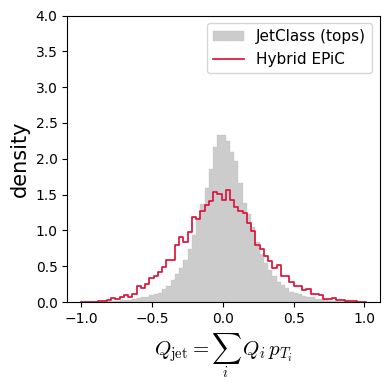

In [42]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,1,figsize=(4,4))

binrange, binwidth, ylim = (-1, 1), 0.03, (0.0, 4.0)
test.histplot('Q_jet', xlabel=r'$Q_{\rm jet} = \sum_{i} \, Q_i\, p_{T_i}$', ylabel='density',  ylim=ylim, binrange=binrange, binwidth=binwidth, fontsize=15, ax=ax, **arg_test)
data.histplot('Q_jet', xlabel=r'$Q_{\rm jet} = \sum_{i} \, Q_i\, p_{T_i}$', ylabel='density', ylim=ylim, binrange=binrange, binwidth=binwidth, fontsize=15, ax=ax, **arg_gen)
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(cmb.workdir / f'multiplicities_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.show()

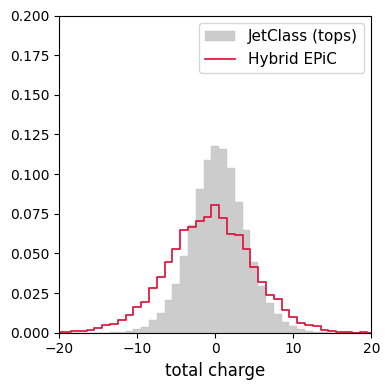

In [43]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,1,figsize=(4,4))

xlim, ylim = (-20, 20), (0, 0.2)
test.histplot('Q_total', xlabel=r'total charge', xlim=xlim, ylim=ylim,  discrete=True, ax=ax, **arg_test)
data.histplot('Q_total', xlabel=r'total charge', xlim=xlim, ylim=ylim, discrete=True, ax=ax, **arg_gen)
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(cmb.workdir / f'multiplicities_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.show()